# EIRP - TFM
$$ TFM = \eta \frac{\text{EIRP}_\text{min}}{N_\text{stars}\nu_\text{rel}} $$
$$ \text{EIRP}_\text{min} = 4 \pi d^2 F_\text{min} $$
$$ F_\text{min} = \text{SNR}_\text{min} \frac{2k_B T_\text{sys}}{A_\text{eff}} \sqrt{\frac{B}{n_\text{pol} \tau_\text{obs} }}$$

and now we trace back all of the values in order to compute the first

In [1]:
import numpy as np
from astropy import units as u

In [2]:
hi, lo = 15.3 * u.GHz, 8.4 * u.GHz
bandwidth = 2 * u.GHz
nu_mean = (hi + lo)/2
nu_rel = bandwidth / nu_mean

In [38]:
T_rx = lambda nu: 10.6*u.K + 0.633 * (nu - 8.41*u.GHz) * (u.K/u.GHz)
T_sky = lambda nu: 568*u.K * (nu / u.GHz)**-1.13 # galactic center 
T_sys = lambda nu: T_rx(nu) + T_sky(nu)

In [72]:
S_N_min = 10 # Czech et al. (2021), Price et al. (2020)
k_B = 1.3806503e-23 * (u.J / u.K) # Boltzmann Constant
D = 13.5 * u.m # antenna diameter
# D = 8 * u.km # antenna syntetized beam
n_antennas = 64
A_eff = .65 * np.pi * (D / 2)**2 * n_antennas
B = 1 * u.Hz # width of the signal
n_pol = 1
tau_obs = 30 * 60 * u.s # 30 minutes

In [73]:
F_min = lambda nu: S_N_min * 2 * k_B * T_sys(nu) / A_eff * np.sqrt(B / (n_pol * tau_obs))

In [74]:
F_min(10 * u.GHz).to(u.W / (u.m)**2)

<Quantity 5.87090725e-26 W / m2>

In [75]:
EIRP_min = lambda nu, d: 4 * np.pi * d**2 * F_min(nu)

In [76]:
import os
import sys
import contextlib

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [77]:
from astropy.table import Table, vstack
from tqdm import tqdm
from targetexplore import Targets, random_pointings

In [78]:
final_table = Table(
    names=[
        "designation",
        "ra", "dec",
        "parallax", "parallax_error",
        "phot_bp_mean_mag", "phot_g_mean_mag", "bp_rp", 
        "distance_gspphot", "distance_gspphot_lower", "distance_gspphot_upper",
        "bp_rp_error",
        "abs_g_mag", "abs_g_mag_error"
    ],
    dtype=["object", *(["float64"]*13)]
)

In [ ]:
N_stars = [0]
for i in tqdm(range(52 * 3), desc="Simulating 3 years of random observations of MeerKAT sky", miniters=1, mininterval=0.1):
    with suppress_output():
        tgts = random_pointings(
            int(10000/52), # CORRECT ONE 
            # 5, # LOWER FOR TESTING
            dec_lims=[-90, 45],
            return_targets=True,
            telescope="MeerKAT", band="5b",
            quality_cut="""
        distance_gspphot > 0 and (distance_gspphot_upper - distance_gspphot_lower) / distance_gspphot < .2
        and phot_g_mean_flux_over_error > 50
        and phot_rp_mean_flux_over_error > 20
        and phot_bp_mean_flux_over_error > 20
        and phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(phot_bp_mean_mag - phot_rp_mean_mag, 2)
        and phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(phot_bp_mean_mag - phot_rp_mean_mag, 2)
        and visibility_periods_used >= 8
        and astrometric_n_good_obs_al > 5
        and astrometric_chi2_al / (astrometric_n_good_obs_al - 5) < 1.44 * GREATEST(1, EXP(-0.4 * (phot_g_mean_mag - 19.5)))
        """
        )
    final_table = vstack([final_table, tgts.table])
    final_table = final_table.group_by("designation").groups.aggregate(lambda g: g[0])
    N_stars.append(len(final_table))

Simulating 3 years of random observations of MeerKAT sky:   0%|                                                                                                            | 0/156 [00:00<?, ?it/s]

In [18]:
from matplotlib import pyplot as plt

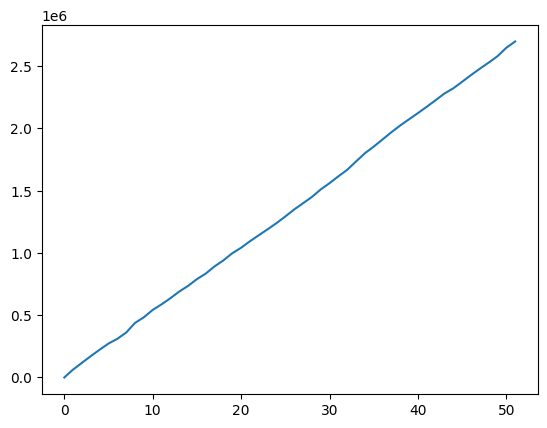

In [19]:
plt.plot(N_stars)

In [20]:
N_stars[-1]

2698568

In [25]:
tgts = random_pointings(
    0,
    telescope="MeerKAT", band="5b",
    return_targets=True,
    query=False
)
tgts.table = final_table

In [26]:
eirp_mins = np.array([EIRP_min(nu_mean, d*u.pc).to(u.W).value for d in tgts.gaia_dist[0]])

In [27]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
counts = Counter(np.ceil(np.log10(eirp_mins)).astype(int))
counts

Counter({np.int64(17): 1643975,
         np.int64(18): 933652,
         np.int64(16): 83654,
         np.int64(19): 29441,
         np.int64(15): 4229,
         np.int64(20): 3508,
         np.int64(14): 102,
         np.int64(13): 7})

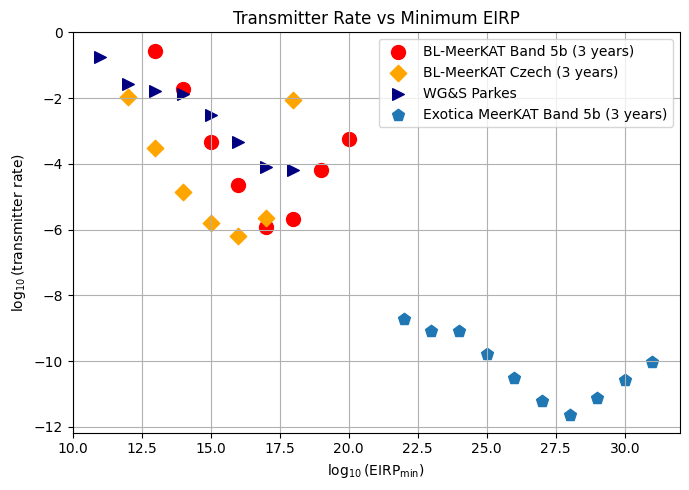

In [70]:
x = np.arange(11, 40)
y_BL_MeerKAT_5b = [np.log10(1 / (nu_rel * counts[k] * 3)) for k in x]

# Plot
plt.figure(figsize=(7,5))
plt.scatter(x, y_BL_MeerKAT_5b, color='red', s=100, label="BL-MeerKAT Band 5b (3 years)")
plt.scatter(x,[np.nan, -1.9674796747967487,
               -3.512195121951219,
               -4.861788617886179,
               -5.804878048780488,
               -6.195121951219512,
               -5.642276422764228,
               -2.0487804878048785,
               *([np.nan]*21)],
            marker='D', color='orange', s=70, label="BL-MeerKAT Czech (3 years)")
plt.scatter(x, [-0.7479674796747973,
                -1.5609756097560976,
                -1.7886178861788622,
                -1.886178861788618,
                -2.5203252032520327,
                -3.333333333333334,
                -4.081300813008131,
                -4.195121951219512,
                *([np.nan]*21)],
            marker='>', color='navy', s=70, label="WG&S Parkes")
plt.scatter(x, y_exotica_MeerKAT_5b, marker='p', s=80, label="Exotica MeerKAT Band 5b (3 years)")
plt.xlabel(r'$\log_{10}(\mathrm{EIRP}_{\min})$')
plt.ylabel(r'$\log_{10}(\mathrm{transmitter\ rate})$')
plt.title('Transmitter Rate vs Minimum EIRP')
plt.grid(True)

plt.legend()
plt.tight_layout()

In [65]:
y_exotica_MeerKAT_5b = [np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.float64(-8.70443290003752),
 np.float64(-9.072409685332115),
 np.float64(-9.072409685332115),
 np.float64(-9.783614146085146),
 np.float64(-10.508345012565586),
 np.float64(-11.214530875225863),
 np.float64(-11.621938409590067),
 np.float64(-11.106980850949911),
 np.float64(-10.57170391900297),
 np.float64(-10.02665219477144),
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf,
 np.inf]